# Learning representations by back-propagating errors

---
**Quick summary:** *paper that introduced and popularized the concept of backpropagation for Neural Networks*

> The task is specified by giving the desired state vector of the output units for each state vector of the input units

Quite convoluted way of saying that to make a network train we need to provide it the intput data with corresponding output we hope to achieve, i.e. a supervised learning. In other words, to map inputs to the outputs with the data.

> ... state of the units in each layer are determined by applying equations (1) and (2) ...

Description of how Neural Networks work, i.e. every output of a layer should correspond to every input node of next layer. And layers are pieced together by a linking linear function with non-linearity.

A Unit consist of 2 values which is a **weight** and a **bias**. In a modern terminology this is reffered to as a *Neuron*

> The total input, $x_{j}$ to unit j is a linear function of the outputs,
> $y_{i}$ of the units that are connected to j and of the weights, $w_{ji}$
> on these connections $$ x_{j} = \sum_{i}y_{i}w_{ji} $$

... the states of the "units", aka Neurons, are evaluated by the linear relation of inputs, which means that an output of neuron $x_{j}$, is a sum of weights of every input to every weight of the Neuron:

```python
    def __call__(self, y: "Units") -> "Units":
        x_j = sum(y_i * w_ji for y_i, w_ji in zip(y.w, self.w))
        return x_j
```

> A unit has a real-valued output, $y_{j}$ which is a non-linear function of its total input $$ y_{j} = {1 \over 1 + e^{-x_{j}} }$$

This is the non-linearity that makes the network learn stuff, which is commonly reffered to as *activation function*. The one mentioned in the paper is *Sigmoid activation function*.

```python
    def sigmoid(self) -> "Scalar":
        return 1 / (1 + math.exp(-self.w))

    def __call__(self, y: "Units") -> "Units":
        x_j = sum(y_i * w_ji for y_i, w_ji in zip(y.w, self.w))
        out = x_j.sigmoid() # add non-linearity
        return out
```

Based on above mentioned ideas it is enough to "build" the basic implementation for a simplest, non-optimized neural network, featuring:
- Scalar: the most basic building block of a Neural network
- Units: aka Neurons
- State Vector: aka Tensor

In [133]:
from autodiff.nn import NeuralNetwork, StateVector

MLP = NeuralNetwork([
    StateVector(2, 10),
    StateVector(10, 1)
])
MLP([1, 1])

[Scalar(data=0.9988252705852085)]

> The aim is to find a set of weights that ensure that for each
> input vector the output vector produced by the network is the
> same as (or sufficiently close to) the desired output vector. If
> there is a fixed, finite set of input-output cases, the total error
> inthe performance ofthe network with a particular set of weights
> can be computed by comparing the actual and desired output
> vectors for every case. The total error E, is defined as:
> $$ \dfrac{1}{2} \sum_{c} \sum_{j} (y_{j,c} - d_{j,c})^2 $$

One of the most fundamental parats of the learning purpose - loss function. Nothing to add, the description is pretty self explanotory. 

In simple words the idea is to calculate the difference between the output of a network and a desired state.

Let's say we want to find the function that can differentiate between these 2 clusters.  

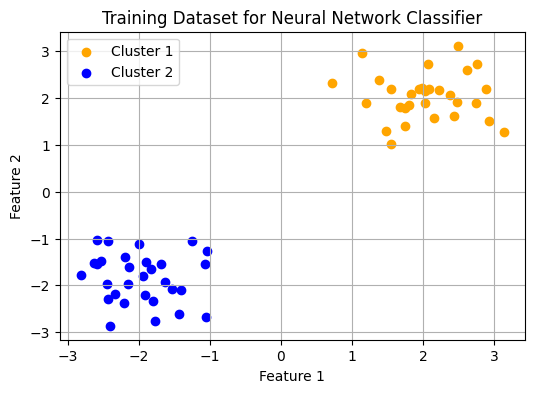

In [134]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import random

# Generating two distinct clusters of data points
np.random.seed(0)

# Generating the specified clusters again to form a dataset for training a neural network classifier
cluster_1 = np.random.normal(loc=[2, 2], scale=[0.5, 0.5], size=(30, 2))
cluster_2 = np.random.normal(loc=[-2, -2], scale=[0.5, 0.5], size=(30, 2))

# Concatenating both clusters into a single dataset
X = np.concatenate([cluster_1, cluster_2], axis=0)
# Creating labels for the clusters (e.g., 0 for cluster_1, 1 for cluster_2)
Y = np.concatenate([np.zeros(30), np.ones(30)])

# Plotting the dataset with labels
plt.figure(figsize=(6, 4))
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='orange', label='Cluster 1')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Cluster 2')
plt.title('Training Dataset for Neural Network Classifier')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


With neural network it is our task to find a state of a network such that it can transform an input $x$ to the desired out put of $y$, i.e.:

$$ x \rightarrow NN \rightarrow y $$


The goal of an error is to calculate the difference between output and expected value. This error will dictate how much the weights should be updated and kick off the backpropagation process. This is also an indicator of the model efficiency:

In [135]:
preds = [MLP(i).pop() for i in X]
total_error = sum([(y_true - y_pred) ** 2 for y_true, y_pred in zip(Y, preds)])
print("Total Error: ", total_error)

Total Error:  Scalar(data=30.067798858115548)


As it can be observerd the total error is pretty high as the network weights are randomized, and thus so are the outputs.

> To minimize & by gradient descent
> it is necessary to compute the partial derivative of E with respect
> to each weight in the network.

The learning process starts with the Error and this value affects the gradient's magnitude of a whole network. This holds true as backpropagation starts from the latest node in a computational graph and works its way backwards. It computes derivatives and propagates them backward through the network, hence the naming "backpropagation".

In a modern Deep Neural network libraries Value differentiation is handled automatically by the network. This is possible because any computation can be represented as a graph. With operations represented as nodes by defining the rule for each type of node, i.e. an operation like "+" or "-", it is as well possible to set the rule for a backward pass, i.e. differentiation. With this, each value shall have the information regarding its "parents" and it becomes possible to apply chain rule to whole network from top to bottom iteratively.

To implement this the most basic building block should be trackable - `Scalar`. To actually implement this we need to add some properties to enable the graph connections in the `Scalar` class defined before. With this feature in place calculating gradients becomes very easy, as each scalar instance can calculate gradient for itself.

In the implementation, there are 3 main operations, i.e. $+$, $*$, $**$, which implement its own backprop method:
```python
def _backward(prev: tuple["Scalar", "Scalar"], d_out) -> tuple[float]:
    lval, rval = prev
    return rval.data * d_out, lval.data * d_out
```

All other operations like $-$ is implemented by reusing established base primitives with addition and multiplication.

All of this information is then used in a backpropagation step using the chain rule, like this:
```python
for scalar, grad in zip(node.prev, node._backward(node.prev, deriv)):
    scalar.grad += grad
```

For additional details refere to implementation code at [model.py](./autodiff/model.py)

In [171]:
random.seed(111)

n_input = 2
n_output = 1
n_hidden = 8

MLP = NeuralNetwork([
    StateVector(n_input, n_hidden),
    StateVector(n_hidden, n_hidden),
    StateVector(n_hidden, n_hidden),
    StateVector(n_hidden, n_output)
])

errors = []

EPOCHS = 30
for epoch in range(EPOCHS):

    error = 0
    for i in range(len(X)):
        y_pred = MLP(X[i]).pop()
        y_pred = y_pred * 0 if y_pred.data < 0.5 else y_pred # clip
        error += (-Y[i] + y_pred) ** 2

    for p in MLP.parameters():
        p.grad = 0.0 # reset gradients

    error.backward() # accumulate gradients

    for p in MLP.parameters():
        p.data += -0.001 * p.grad # update weights

    errors.append(error.data)
    if epoch % 5 == 0:
        print("Error: ", "{:.7f}".format(error.data)) 

Error:  27.3598716
Error:  6.6910630
Error:  2.6713025
Error:  1.1942969
Error:  0.7094908
Error:  0.5932198


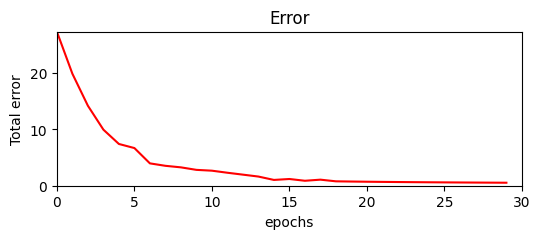

In [172]:
# Error plot
fig, ax = plt.subplots(figsize=(6, 2))
ax.set_xlim(0, len(errors))
ax.set_ylim(0, max(errors))
ax.set_xlabel("epochs")
ax.set_ylabel("Total error")
ax.set_title("Error")

err_line, = ax.plot(errors, label='Total error', color='red')

*Note: this implementation is not stable as Scalar does not implement neither regularization / normalization nor proper weight initialization commonly seen in modern networks, thus, training progress will differ noticeably from run to run withhout specifying random seed.*